# AMD&BD: Assignment 1 part II

By Kasper Bouwens, Alexander van Someren, Casper Thuis and Wolf Vos

In [3]:
import sys
if sys.version_info[0] != 2:
    print "Please use python 2.7 for grading this homework."

# import convention for pandas
import pandas as pd
import scipy
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light
from scipy.optimize import minimize
from matplotlib.patches import Ellipse
from scipy.stats import chi2
%matplotlib inline

# Wifi tracking at KPMG-restaurant

## Introduction

The following part documents the analysis of the Wifi data at the KMPG restaurant. **TODO: introduction**

## Setup

### Reading in the data

In this part, we read the data into a pandas `DataFrame` and define the router positions provided by KPMG. Furthermore, we add a `DateTime` column, to make the measured times more readable. Finally we add a `temp_id` field that is simply the concatination of `typeNr`, `subTypeNr` and `seqNr`.

In [4]:
# read in your data
df = pd.read_csv('UvA-wifitracking-exercise-prepped-data.csv', dtype={"typeNr":str, 'subTypeNr': str, "seqNr":str})

# a very useful pandas facility, to group a DataFrame using one (or more) index values as keys
groups = df.groupby(by=['droneId'])

# the 'groups' variable is just another object
# it produces a sequence of group names together with a chunk of data (the group) 
# we can iterate over it, and do something with it

# Define router positions
kpmg_router_positions = {
    "Lima":( 5.82, 5.48),
    "Mike":(11.33, 9.43),
    "Kilo":(12.39, 6.77),
    "Oscar":(2.48, 7.36),
    "Alpha":(8.53, 2.16),
    "India":(2.18, 5.61),
    "November":(8.34, 4.13),
    "Hotel":(5.43, 4.71),
    "Romeo":(10.99, 5.94),
    "Quebec":(6.82, 9.78),
    "Papa":(9.9, 10.39)
}

# for key, value in kpmg_router_positions.iteritems():
#     print value
#     kpmg_router_positions[key] = ( value[0]*10,  value[1]*10  ) 
# [i*10 for i in kpmg_router_positions.key]
df['measuredDateTime'] = pd.to_datetime(df['measurementTimestamp'], unit='ms')
df['temp_id'] = df.typeNr.str.cat(df.subTypeNr).str.cat(df.seqNr)
kpmg_router_positions

{'Alpha': (8.53, 2.16),
 'Hotel': (5.43, 4.71),
 'India': (2.18, 5.61),
 'Kilo': (12.39, 6.77),
 'Lima': (5.82, 5.48),
 'Mike': (11.33, 9.43),
 'November': (8.34, 4.13),
 'Oscar': (2.48, 7.36),
 'Papa': (9.9, 10.39),
 'Quebec': (6.82, 9.78),
 'Romeo': (10.99, 5.94)}

In [5]:
df.head()

sourceMac typeNr subTypeNr seqNr  \
0  3c560f25491f3902870e392f58973155c284fa24a736ef...      0         4    12   
1  3c560f25491f3902870e392f58973155c284fa24a736ef...      0         4    12   
2  3c560f25491f3902870e392f58973155c284fa24a736ef...      0         4    12   
3  3c560f25491f3902870e392f58973155c284fa24a736ef...      0         4   268   
4  3c560f25491f3902870e392f58973155c284fa24a736ef...      0         4    12   

   retryFlag  measurementTimestamp   droneId  signal        measuredDateTime  \
0          0         1423136407778     Oscar     -57 2015-02-05 11:40:07.778   
1          0         1423136407779     Hotel     -68 2015-02-05 11:40:07.779   
2          0         1423136407784      Papa     -60 2015-02-05 11:40:07.784   
3          0         1423136407788     Oscar     -59 2015-02-05 11:40:07.788   
4          0         1423136407788  November     -68 2015-02-05 11:40:07.788   

  temp_id  
0    0412  
1    0412  
2    0412  
3   04268  
4    0412

### Identifying seperate packages

The above explained (and declared) `temp_id` - column is not the final package-id because the `seqNr` variable repeats itself. Therefore, the task of identifying the seperate packages is still at hand. We can use the `measurementTimestamp` for this, assuming that the measurement times from a single package should not be too far apart.

In [6]:
def identify_packages(df, max_time=500):
    # Make a copy of the dataframe
    d = df.copy(deep=True)
    d['id'] = 0
    i = 0
    for num in d.temp_id.unique():
        i += 1
        df_seqNrs = d[d['temp_id'] == num]

        values =(df_seqNrs['measurementTimestamp'] - df_seqNrs['measurementTimestamp'].shift())

        for tupl in values.iteritems():
            if tupl[1] > max_time:
                i += 1
                d.set_value(tupl[0], 'id', i)
            else:
                d.set_value(tupl[0], 'id', i)
    return d

The question now however, is what "too" far apart is. Therefore we plot the number of different packages against the maximum number of time difference below from $10$ *ms* to 5000 *ms*.

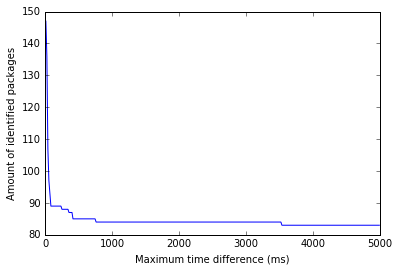

In [7]:
number_of_packages = []
for i in range(10,5000,15):
    df = identify_packages(df, max_time=i)
    number_of_packages.append(len(df.id.unique()))


plt.plot(range(10,5000,15),number_of_packages)
plt.xlabel("Maximum time difference (ms)")
plt.ylabel("Amount of identified packages")

We clearly see that from zero to 250 *ms* the number of identified packages decreases drastically and stabalizes from 500 *ms*. From 800 *ms* or so, the number stabalizes untill 3.5 seconds. This could mean that this is the maximum of time difference caused by router hardware issues and is thus a good number to use for identifying packages. It is good to realize that every value from 500 *ms* and higher will only cause very few packages to merge, so most packages will ramain the same.

In [8]:
df = identify_packages(df, max_time=1000)

## Estimation of device position and uncertainty

In this section we will use the above identified packages to estimate the device position for each package. To do this we will minimize

$$ \chi^2 (x,y) = \sum_i \frac{\left( S_i - P^i_r (x,y)\right)^2}{\sigma_i^2} $$

where $S_i$ is the measured signal strength we sum over the routers and

$$ P_r^i(x,y) = Pt + 20 \log_{10}(\frac{c}{4\pi f}) - 10 \log_{10}((x - x_i)^2 + (y - y_i)^2 + Z^2 )\\ $$

is a modified version of the Friis space equation that gives the expected signal strength for a given $x$ and $y$ location. For this case, height Z=2 since all the routers are 3 *m* above the ground and all smartphones are 1 *m* above the ground.

The above translates in code as follows:

In [9]:
# Declaration of global constants
Z = 2                      # The height of the routers
c = speed_of_light         # The speed of light
f = 2.4*np.power(10,9)     # 2.4 GHz


# Friis equation defined in two dimesions with Pt added as variable since transmission power is unknown
friis_xy = lambda x,y,Pt,xi,yi : Pt + 20*np.log10(c/(4*np.pi*f)) - 10*np.log10(np.square(x-xi) + np.square(y-yi) + np.square(Z))

# The chi-squared equation that we will minimize
def chi_squared_pt(xy,signal_strengths,router_positions,sigma):
    """
    Return the chi_squared value
    """
    chi_squared = 0
    # For each router calculate the normalised residual and sum it to obtain the chi squared value
    for i, router_pos in enumerate(router_positions):
        chi_squared += np.divide(np.square(signal_strengths[i] - friis_xy(*((xy[0],xy[1],xy[2])+router_pos))), np.square(sigma))
    return chi_squared

# Helper function that calculates the risiduals
def calc_residuals(xy,signal_strengths,router_positions,sigma):
    """
    Return the residuals
    """
    residuals = []
    for i, router_pos in enumerate(router_positions):
        residuals.append(np.divide(signal_strengths[i] - friis_xy(*((xy[0],xy[1],xy[2])+router_pos)), sigma))
    return residuals

The next step is to minimize the $\chi^2$ function to obtain the optimal device positions. This is done in the `calculate_positions` method below.

In [10]:
def calculate_positions(df, sigma_expected, initial_guess):
    """
    Calculate device positions given the data frame.
    """
    # Filter packages with less than three package measurements
    viable_indexes = [i for i in df.id.unique() if sum(df['id'] == i) > 2 ]
    viable_df = df.loc[df['id'].isin(viable_indexes)]

    res_chi = []
    res_xy = []
    res_size = []
    res_chi_per_size = {}
    result_dict = {}
    for i in viable_df['id'].unique():
        # Get router coordinates for drone_id that recieved current package
        router_coor = [kpmg_router_positions[drone] for drone in viable_df[viable_df['id'] == i]['droneId']]
        
        # Get the signal strengths for this package
        signal_strengths_kpmg = np.array(viable_df[viable_df['id'] == i]['signal'])
        
        
        # Minimize the chi-squared function
        res = minimize(chi_squared_pt, initial_guess
                       , (signal_strengths_kpmg, router_coor, sigma_expected),method='Powell')

        result_dict[i] = {'x': res.x[0], 'y': res.x[1]}
        
            
        if len(signal_strengths_kpmg) in res_chi_per_size:
            res_chi_per_size[len(signal_strengths_kpmg)].append(res.fun)
            
        else:
            res_chi_per_size[len(signal_strengths_kpmg)] = [res.fun]
            
        res_chi += [res.fun]
        res_xy += [res.x]
        res_size += [len(signal_strengths_kpmg)]

    return [res_xy, res_chi, res_size, res_chi_per_size, result_dict]

### Parameters for the optimization procedure

To calculate the positions, we need provide two extra parameters. The expected sigma (or noise) in our system and an initial guess for the coordinates, which will help the minimization algorithm.

#### Expected noise

One way to assess the amount of noise in the system is by choosing $\sigma$ in such a way that the $\chi^2$ value matches the degrees of freedom in the system.

In an experiment like this, we expect that avarage value of $\chi^2$ is equal to the degrees of freedom in the system. In the best cases, we have 11 routers (or datapoints) for a package and we have 3 parameters to estimate, that will result in $11-3=8$ degrees of freedom. However, as we have seen above, most packages are not measured by all routers. Therefore, one could argue that we should define the degrees of freedom seperately for each number of measurements per package (e.g. packages that were recieved by all routers get 8 DoF, packages that were recieved by 10 routers get 7 DoF). An advantage of this approach would be that we obtain a different expected noise for each number of measurements, which is in agreement with the idea that we expect less noise when the package is measured by more routers.

This approach sadly, also has a major disatvantage. It will work better with more data, and will probably work poorly for the (small) dataset at hand. Imagine that for example there are only two packages that were measured by 10 drones, of which one was measured with a great amount of noise, then the the matching of the $\chi^2$ value to the number of degrees of freedom will yield a $\sigma$ that is too high.

Therefore we could try a different approach: to combine all the measurements and estimate one $\chi^2$ value and just set it to match the average degrees of freedom in the system. Let us first look at the distribution of the number of measurements per package.

In [11]:
def get_measurements_per_id(d):
    return d.pivot_table(index='id', values='droneId',aggfunc=lambda x: len(x))

def plot_number_of_measurements(d):
    measurements_per_id = get_measurements_per_id(d)
    ax = measurements_per_id.hist()
    ax.set_xlabel("Number of measurements per package")
    ax.set_ylabel("Count")

Average measurements per package: 3.70238095238
1     25
2     21
10     9
3      9
5      6
4      5
11     3
7      3
9      1
8      1
6      1
Name: droneId, dtype: int64


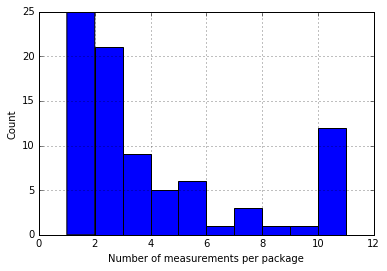

In [12]:
plot_number_of_measurements(df)
measurements_per_id = get_measurements_per_id(df)
print "Average measurements per package: " + str(measurements_per_id.mean())
print get_measurements_per_id(df).value_counts()

As can be seen, the average number of measurements per package, 3.7, is quite low. If we look at the histogram, this is due to the big number of packages with only one or two measurements. Two measurements are obviously not enough to perform triangulation, so we remove them in our further analysis. 

In [13]:
viable_indexes = [i for i in df.id.unique() if sum(df['id'] == i) > 2 ]
df = df.loc[df['id'].isin(viable_indexes)]

Furthermore we choose the largest bin (10 measurements) to estimate our sigma. With 10 measurements, we have $10-3=7$ DoF, so we will look for a $\chi^2$ value of 7.

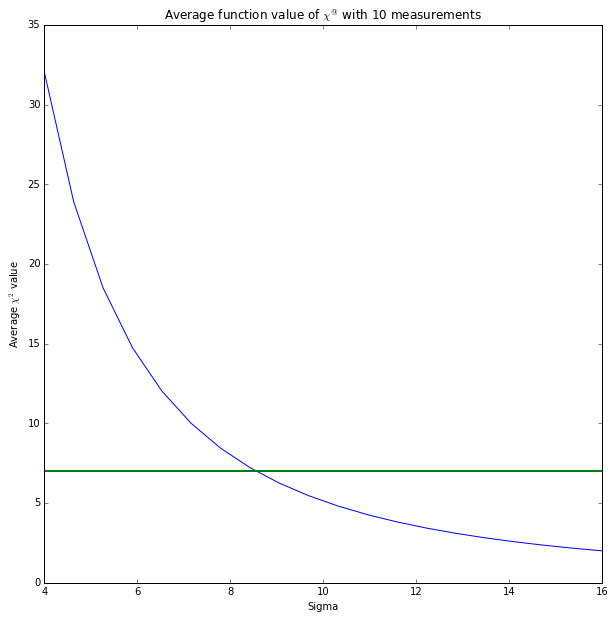

In [14]:
center_of_routers = np.array(kpmg_router_positions.values()).mean(axis=0)
sigma_space = np.linspace(4,16,20)
chi_mean_values = []
for sigma_expected in sigma_space:
    res_xy, res_chi, res_size, res_chi_per_size, _ = calculate_positions(df, sigma_expected, np.append(center_of_routers, -25))
    chi_mean_values.append(np.mean(res_chi_per_size[10]))
plt.figure(figsize=(10, 10))
plt.xlabel('Sigma')
plt.ylabel('Average $\chi^2$ value')
plt.title('Average function value of $\chi^@$ with 10 measurements')
plt.plot(sigma_space, chi_mean_values)
plt.plot([4, 16], [7, 7], linestyle='-', lw=2)
# plt.plot([8.5, 8.5], [0, 35], linestyle='-', lw=2)

We obtain a $\sigma$ of 8.5.

#### Initial guess

The other parameter for the optimization algorithm that we need to choose is the initial guess for the optimiztion. In a real life situation, you could use some clever heuristic like the previous location of the phone, but a simpler, naive guess is the average of router positions or the center of routers.

### Results

We are now ready to calculate the devices positions with an expected error of 8.5 and an initial guess that is the center of the routers:

In [15]:
sigma_expected = 8.5
center_of_routers = np.array(kpmg_router_positions.values()).mean(axis=0)
print center_of_routers

[ 7.65545455  6.52363636]


#### First round

Now, we run the actual experiment.

In [16]:
res_xy, res_chi, res_size, _, _ = calculate_positions(df, sigma_expected, np.append(center_of_routers, -25))

We plot a histogram of the $\chi^2$ values and compare them with the $\chi^2$ distribution. Since we use the $\chi^2$ values of the entire dataset and, as we seen above, the 7 DoF does not hold for every datapoint, we should not expect a perfect fit.

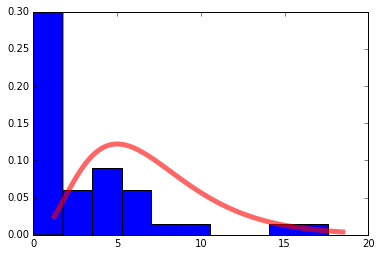

In [17]:
x = np.linspace(0, 50, 100)
degfree = 7
fig, ax = plt.subplots(1, 1)
x = np.linspace(chi2.ppf(0.01, degfree),
                chi2.ppf(0.99, degfree), 100)
ax.plot(x, chi2.pdf(x, degfree),
       'r-', lw=5, alpha=0.6, label='chi2 pdf')
_ = plt.hist(res_chi, normed=True)

As expected, the fit is not perfect. However, it does appear to follow some $\chi^2$ distributions, or maybe a combination of $\chi^2$ distributions.

To be better able to assess the quality of the model and more specifically to assess the uncertainty of our system, we make a historgram of the normalized residuals (also called a pull distribution). This distribution should be a normal distribution with a mean of zero (that is how we optimized) and a standard deviation of one (because we devide by the expected noise).

Mean: 9.97635358769e-05
Std:  0.709072517589


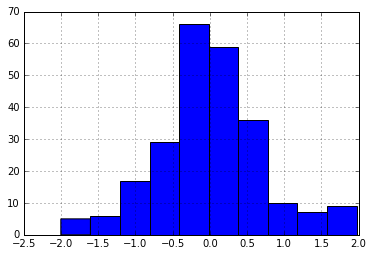

In [18]:
# TODO: also plot residuals for packages with 10 measurements
residuals = []
for i, temp_id in enumerate(df.id.unique()):
    rpos = [kpmg_router_positions[drone_id] for drone_id in df[df.id==temp_id]['droneId']]
    residuals += calc_residuals(res_xy[i], list(df[df.id==temp_id]['signal']), rpos, sigma_expected)
residuals = pd.Series(residuals)
_ = residuals.hist()
print "Mean: " + str(residuals.mean())
print "Std:  " + str(residuals.std())

We see that the distribution is nicely centered around zero. However, the standard deviation is lower than one, so despite the earlier attempt to match the $\chi^2$ value to the degrees of freedom in the system, a $\sigma$ of 8.5 seems to be a slight overestimation of the noise in the system.

#### Round 2

By experiments, we found that a $\sigma$ of 6 provided a pull distributions with a standard deviation of ~1.

In [19]:
sigma_expected = 6
center_of_routers = np.array(kpmg_router_positions.values()).mean(axis=0)
print center_of_routers

res_xy, res_chi, res_size, _, result_dict = calculate_positions(df, sigma_expected, np.append(center_of_routers, -25))

[ 7.65545455  6.52363636]


Mean: 0.000141331677201
Std:  1.00451939992


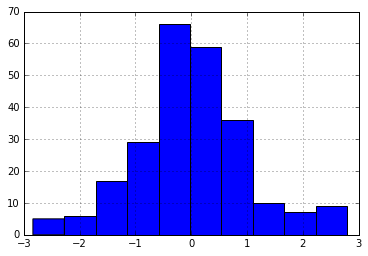

In [20]:
# TODO: also plot residuals for packages with 10 measurements
residuals = []
for i, temp_id in enumerate(df.id.unique()):
    rpos = [kpmg_router_positions[drone_id] for drone_id in df[df.id==temp_id]['droneId']]
    residuals += calc_residuals(res_xy[i], list(df[df.id==temp_id]['signal']), rpos, sigma_expected)
residuals = pd.Series(residuals)
_ = residuals.hist()
print "Mean: " + str(residuals.mean())
print "Std:  " + str(residuals.std())The derivato

The choice of $\sigma = 6$ seems to reflect the amount of noise in the system well. Therefore we will use these results to plot the positions.

### Estimating position uncertainty

In the previous section, we have tried to find the device positions that minimize the $\chi^2$ function given an expected signal noise. However, we are not only interested in the most likely positions, but also want to assess the spacial uncertainty of our estimation.

To do this we rederive the B matrix. The derivation are quite long and therefore are not included.

The results however are shown below. 




$
\newcommand{\lp}{\left(}
\newcommand{\rp}{\right)}
\newcommand{\lb}{\left[}
\newcommand{\rb}{\right]}
\newcommand{\Bmat}{{\bf B}}
$
$
\begin{align*}
\Bmat &= \sum_i \frac{1}{ \sigma_i^2} \begin{pmatrix}
       \lp \frac{\partial P^i_r(x_0, y_0)}{ \partial x}\rp^2 & \frac{\partial P^i_r(x_0, y_0)}{ \partial x}\frac{\partial P^i_r(x_0, y_0)}{ \partial y} & \frac{\partial P^i_r(x_0, y_0)}{ \partial x}\frac{\partial P^i_r(x_0, y_0)}{ \partial P_t} \\
       \frac{\partial P^i_r(x_0, y_0)}{ \partial x}\frac{\partial P^i_r(x_0, y_0)}{ \partial y}    & \lp\frac{\partial P^i_r(x_0, y_0)}{ \partial y}\rp^2 & \frac{\partial P^i_r(x_0, y_0)}{ \partial y}\frac{\partial P^i_r(x_0, y_0)}{ \partial P_t} \\
       \frac{\partial P^i_r(x_0, y_0)}{ \partial x}\frac{\partial P^i_r(x_0, y_0)}{ \partial P_t} & \frac{\partial P^i_r(x_0, y_0)}{ \partial y}\frac{\partial P^i_r(x_0, y_0)}{ \partial P_t}  & \lp \frac{\partial P^i_r(x_0, y_0)}{ \partial P_t}\rp^2
     \end{pmatrix} \\  
\text{Where} \frac{\partial P^i_r(x_0, y_0)}{ \partial P_t} = 1\\
\Bmat &= \sum_i \frac{1}{ \sigma_i^2} \begin{pmatrix}
       \lp \frac{\partial P^i_r(x_0, y_0)}{ \partial x}\rp^2 & \frac{\partial P^i_r(x_0, y_0)}{ \partial x}\frac{\partial P^i_r(x_0, y_0)}{ \partial y} & \frac{\partial P^i_r(x_0, y_0)}{ \partial x} \\
       \frac{\partial P^i_r(x_0, y_0)}{ \partial x}\frac{\partial P^i_r(x_0, y_0)}{ \partial y}    & \lp\frac{\partial P^i_r(x_0, y_0)}{ \partial y}\rp^2 & \frac{\partial P^i_r(x_0, y_0)}{ \partial y} \\
       \frac{\partial P^i_r(x_0, y_0)}{ \partial x} & \frac{\partial P^i_r(x_0, y_0)}{ \partial y}  & 1
     \end{pmatrix} \\
\end{align*}
$

Invering the B matrix results in calculating variance in the x and y. Which are in the frist and second diagonal elements respectively. 

In [21]:
derivative_x = lambda x,y,xi,yi: (-20*x + 20*xi)/(np.log(10)*(np.square(x - xi)+np.square(y - yi)+np.square(2)))
derivative_y = lambda x,y,xi,yi: (-20*y + 20*yi)/(np.log(10)*(np.square(x - xi)+np.square(y - yi)+np.square(2)))

def calculate_std(res_xy, sigma_expected, result_dict):

    res_std = []
    
    for i in result_dict:
        delta_x_squared = 0
        delta_x = 0
        delta_y = 0
        delta_y_squared = 0
         
        for router_pos in kpmg_router_positions.items():
            coor = (result_dict[i]['x'], result_dict[i]['y'])
            delta_x_squared += np.square(derivative_x(*coor + router_pos[1]))/np.square(sigma_expected)
            delta_x += derivative_x(*coor + router_pos[1])/np.square(sigma_expected)
            delta_y += derivative_y(*coor + router_pos[1])/np.square(sigma_expected)
            delta_y_squared += np.square(derivative_y(*coor + router_pos[1]))/np.square(sigma_expected)
        
        B = np.matrix([[delta_x_squared, delta_x*delta_y, delta_x],[delta_x*delta_y, delta_y_squared, delta_y], [delta_x, delta_y, 1]])     
        B_inv = np.linalg.inv(B)
        std_x = np.sqrt(B_inv[0,0])
        std_y = np.sqrt(B_inv[1,1])
        res_std.append(tuple([std_x, std_y]))
        result_dict[i] = {'x': result_dict[i]['x'], 'y': result_dict[i]['y'], 'std_x': std_x , 'std_y': std_y}
        
    return [res_std, result_dict]


res_std, result_dict  = calculate_std(res_xy, sigma_expected, result_dict)

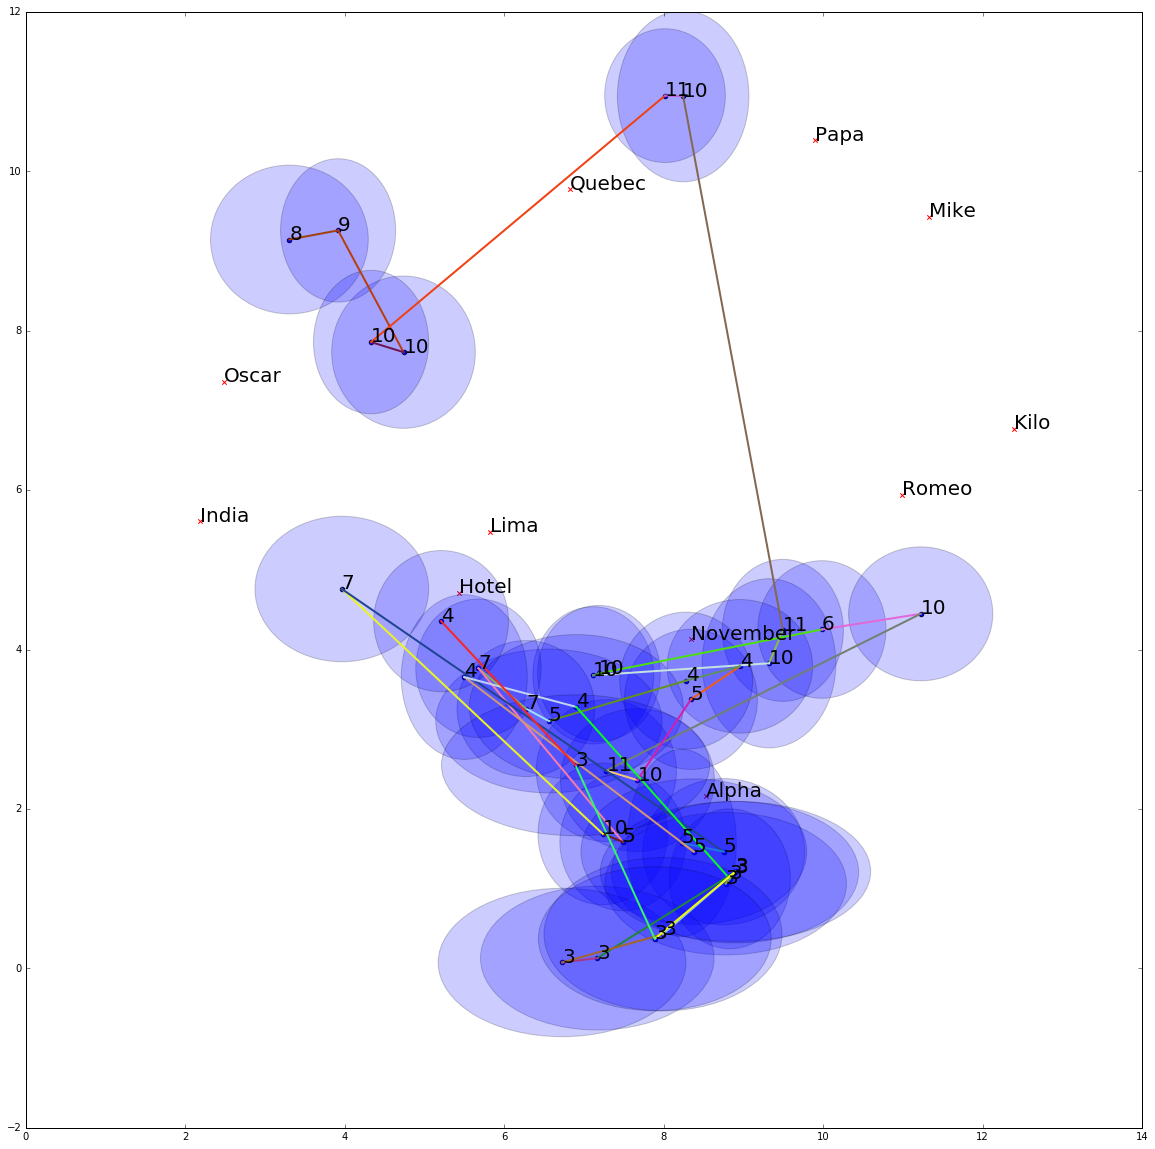

In [22]:
def plot_positions(res_xy, res_std, res_size):
    plt.figure(figsize=(20, 20))
    ax = plt.gca()
    plt.scatter([router_x[1][0] for router_x in kpmg_router_positions.items()], [router_y[1][1] for router_y in kpmg_router_positions.items()], color='r', marker='x', label='Router positions')

    # Annotate Routers
    for name in kpmg_router_positions:
        ax.annotate( str(name), kpmg_router_positions[name], fontsize = 20 )
    
    for index, xy in enumerate(res_xy):
        
        # Skip first index
        if index > 0:
            plt.plot([xy[0], res_xy[index-1][0]], [xy[1], res_xy[index-1][1]], c=[np.random.rand(1),np.random.rand(1),np.random.rand(1)], linestyle='-', lw=2)

        plt.scatter(xy[0],xy[1], label="Estimated XY")
        ax.annotate(str(res_size[index]), (xy[0],xy[1]), fontsize=20)
        ell = Ellipse(xy[:2], width=res_std[index][0], height=res_std[index][1], alpha=0.2)
        ax.add_artist(ell)
      
plot_positions(res_xy, res_std, res_size)

### System resolution


In [23]:
def estimate_system_resolution(res_std):
    print "X resolution: " +  str(np.mean([x[0] for x in res_std]))
    print "Y resolution: " + str(np.mean([y[1] for y in res_std]))
    print "Combined resolution: " + str(np.mean([np.mean([x[0] for x in res_std]),np.mean([y[1] for y in res_std])]))
    
estimate_system_resolution(res_std)

X resolution: 2.06371477138
Y resolution: 1.81930555462
Combined resolution: 1.941510163


### Average transmission power

Average transmission power: -20.0408493767


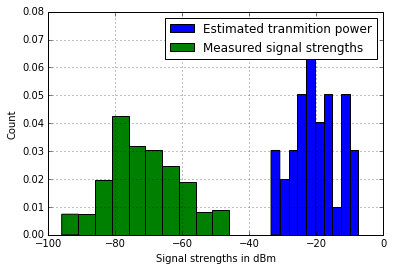

In [24]:
transm_powers = pd.Series(np.array(res_xy)[:,2])
print "Average transmission power: "  + str(transm_powers.mean())
ax = transm_powers.hist(label="Estimated tranmition power", normed=True)
ax.set_xlabel("Signal strengths in dBm")
ax.set_ylabel("Count")
df.signal.hist(label="Measured signal strengths", normed=True)
_ = ax.legend()

The estimated transmission powers look reasonable. They are never higher than one. Also, they are quite a bit higher than the measured signal strengths. This is obvious since the signal should weaken according to the Friis equation.

## Combining nearby packages

As the assignment mentions: 
> Some wifi packets were sent so shortly after each other that the device could not have moved very far if at all.

The suggested approach is to "compose another chi-squared method to combine the locations of wifi packets that are closely spaced in time into one location". This time, the chi-squared minimization will not be trying to minimize the sum of squared distances in signal strengths, but the sum of squared euclidean distances between the optimal combined position and the earlier positions. This translates to minimizing:

$$
\newcommand{\norm}[1]{\left\lVert#1\right\rVert}
\chi^2 (\vec{x}) = \sum_{p=1}^{\text{P}} 
\norm{\frac{
\left(
\vec{x}_p
-
\vec{x}
\right)^2
}
{
\vec{\sigma_p}^2
}
}
$$

Where we sum over the packages that are combined to the current packages and:

$
\vec{x} = 
\begin{bmatrix}
x \\
y \\
\end{bmatrix}
$ 
Is the vector of the x and y location of the combined measurement,

$
\vec{x}_p = 
\begin{bmatrix}
x_p \\
y_p \\
\end{bmatrix}
$
Is the vector of the previously estimated x and y location of the original package and:

$
\vec{\sigma}_p = 
\begin{bmatrix}
\sigma_{xp} \\
\sigma_{yp} \\
\end{bmatrix}
$
Is the vector of previously estimation of the uncertainties of that package.

The first thing to do is identify packages that are close to each other in time. We use a time threshold of 1000 ms. This choice is not arbitrary and corresponds to the choice made earlier about seperating packages (we chose a number slighlty away from the bending point from the plot of the amount of unique packages as a function of the maximum time difference we allowed).

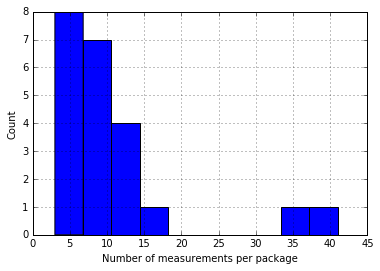

In [25]:
def get_measurements_per_combined_id(d):
    return d.pivot_table(index='combined_id', values='droneId',aggfunc=lambda x: len(x))

def plot_number_of_measurements_per_combined_id(d):
    measurements_per_id = get_measurements_per_combined_id(d)
    ax = measurements_per_id.hist()
    ax.set_xlabel("Number of measurements per package")
    ax.set_ylabel("Count")

def combine_package(d1, time_threshold=1000):
    df_t = d1.copy(deep=True)
    initial_times = dict((i,df_t.measurementTimestamp[df_t.id == i].min()) for i in df_t.id.unique())
    initial_times = pd.DataFrame.from_dict(initial_times, orient='index')
    initial_times.columns = ['initial_time']
    
    original_ids = initial_times.index
    df_t['combined_id'] = df_t['id']
    
    for original_id in original_ids:
        if original_id in df_t['combined_id'].unique():
            initial_time = initial_times['initial_time'][original_id]
            initial_times['differences'] = initial_times - initial_time
            to_be_combined = initial_times[(0 < initial_times['differences']) & (initial_times['differences'] < time_threshold)].index
            if to_be_combined != []:
                df_t['combined_id'].replace(list(to_be_combined), original_id, inplace=True)
    return df_t

d2 = combine_package(df)
plot_number_of_measurements_per_combined_id(d2)

We see that some of the bigger packages "merged" as we now have two packages with over 35 measurements. The next step is implementing the chi-squared function we defined above. And calculating the optimal combination coordinates.

--------------
Result from chi_square minimization: [ 4.15679972  8.41891056]
Average of package positions:        [ 4.0716043   8.49706836]
Difference in meter                  0.11561531273
--------------
Result from chi_square minimization: [ 7.86951165  3.49698881]
Average of package positions:        [ 7.93297647  3.50060351]
Difference in meter                  0.063567677903
--------------
Result from chi_square minimization: [ 5.86989739  2.76148444]
Average of package positions:        [ 6.564953    2.75319209]
Difference in meter                  0.69510506754
--------------
Result from chi_square minimization: [ 8.0897973   0.73968647]
Average of package positions:        [ 8.07912056  0.71905993]
Difference in meter                  0.0232259935049
--------------
Result from chi_square minimization: [ 8.30398355  0.66716599]
Average of package positions:        [ 8.26046075  0.67216402]
Difference in meter                  0.0438088389754


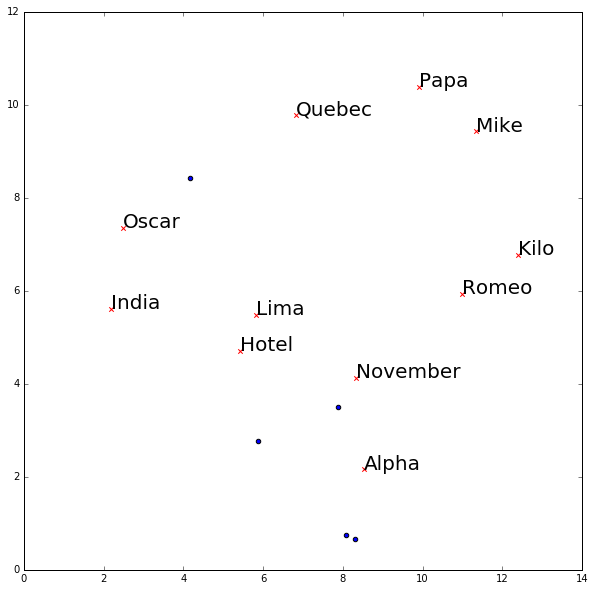

In [28]:
def chi_squared_positions(optimal_xy,estimated_positions,location_uncertainty):
    """
    Return the chi_squared value
    """
    chi_squared = 0
    # For each router calculate the normalised residual and sum it to obtain the chi squared value
    for i, estimated_position in enumerate(estimated_positions):
        chi_squared += np.linalg.norm(np.divide(np.square(estimated_position - optimal_xy), np.square(location_uncertainty[i])))
    return chi_squared


def calculate_positions_coordinates(df, result_dict, initial_guess):
    """
    Calculate device positions given the data frame.
    
    Returns
    """
    res_chi = []
    res_xy = []
    res_size = []
    res_chi_per_size = {}
     
    for i in df['combined_id'].unique():
       
        package_ids = df[df['combined_id'] == i]['id'].unique()
        if len(package_ids) > 1:
            positions = [[result_dict[j]['x'], result_dict[j]['y']] for j in package_ids]
            variances = [[result_dict[j]['std_x'], result_dict[j]['std_y']] for j in package_ids]

            # Minimize the chi-squared function
            res = minimize(chi_squared_positions, initial_guess
                           , (positions, variances),method='Powell')
            print "--------------"
            print "Result from chi_square minimization: " + str(res.x)
            print "Average of package positions:        " + str(np.array(positions).mean(axis=0))
            print "Difference in meter                  " + str(np.linalg.norm(np.array(res.x)-np.array(positions).mean(axis=0)))
            res_chi += [res.fun]
            res_xy += [res.x]
    
    return [res_xy, res_chi]

res_xy_combined, res_chi_combined = calculate_positions_coordinates(d2, result_dict, center_of_routers)

def plot_1(res_xy):
    plt.figure(figsize=(10, 10))
    ax = plt.gca()
    plt.scatter([router_x[1][0] for router_x in kpmg_router_positions.items()], [router_y[1][1] for router_y in kpmg_router_positions.items()], color='r', marker='x', label='Router positions')

    # Annotate Routers
    for name in kpmg_router_positions:
        ax.annotate( str(name), kpmg_router_positions[name], fontsize = 20 )
    
    for index, xy in enumerate(res_xy):
        plt.scatter(xy[0],xy[1], label="Estimated XY")
      
plot_1(res_xy_combined)

To say something about the usefullness of this method, we also printed the average of the locations of the packages that are combined and the difference between that simple method and the chi-squared minimization method presented above. The highest diffence was 0.7 meters, which is not that high if you consider the uncertainties of the original locations.

## Concluding remarks

To summarize, we used packages recieved by 11 routers at the KPMG restaurant to assess the positions of a mobile device. To do this, we used the Friis equation in combination with chi-squared minimization. The system resolution was 1.9 meters, which is quite high compared to for example GPS. It would be nice to have annotated data (e.g. obtained using a motion capture system) to be better able to assess the noise in the system and try to find patterns in this noise so you could improve the resolution of the system.

We did not get to implementing the noise assesment for the combined packages, but would like to share our thoughts on this issue. The estimation of the noise might be done on similiar method as previous exercise. By use of a taylor expansion and obtaining the covariance matrix. 

A final remark: before we created a chi-squared method for the positions, we just combined the packages and performed the analysis in an equal manner as our main analysis. It would be interesting to compare that approach to the one suggested above. For real time application, this approach would be better since it requires less computations.